In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
from einops import rearrange
import json
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tqdm.keras import TqdmCallback

#sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-25 13:03:48.764517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
#import models
import utils

Shapes : (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


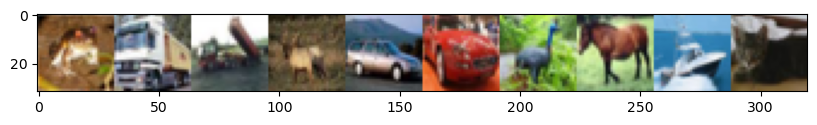

In [5]:
P = { "training_data" : "cifar10" }

if P["training_data"] == "mnist":
    dataset = tf.keras.datasets.mnist
elif P["training_data"] == "fashion_mnist":
    dataset = tf.keras.datasets.fashion_mnist
elif P["training_data"] == "cifar10":
    dataset = tf.keras.datasets.cifar10
else:
    raise Exception("Unknown dataset.")

(x_train, y_train), (x_val, y_val) = dataset.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_val   = x_val.astype(np.float32)   / 255.0

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, -1)
    x_val   = np.expand_dims(x_val,   -1)

print("Shapes :", x_train.shape, y_train.shape, x_val.shape, y_val.shape)

fig, ax = plt.subplots(1, 1, figsize=(10,1))
plt.imshow(rearrange(x_train[:10], "b h w c -> h (b w) c"));

In [6]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, DepthwiseConv2D, Flatten
from tensorflow.keras.regularizers import L2

In [10]:
def conv230425(
        input_shape,
        filters,
        kernel_sizes,
        strides,
        activations,
        use_bias=False,
        regularizer=None,
):
    assert len(input_shape) == 3
    depth = len(filters)
    assert isinstance(filters, list)
    assert isinstance(kernel_sizes, list) and len(kernel_sizes) == depth
    assert isinstance(strides, list) and len(strides) == depth
    assert isinstance(activations, list) and len(activations) == depth

    if regularizer is not None:
        regularizer = eval(regularizer)

    inp = Input(shape=input_shape, name="input")
    x = inp

    for layer, (f, k, s, a) in enumerate(zip(filters, kernel_sizes, strides, activations)):
        x = Conv2D(
            filters = f,
            kernel_size = k,
            strides = s,
            use_bias = use_bias,
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer,
            name=f"conv2d_{layer}"
        )(x)
        if a != "linear":
            x = eval("tf.keras.activations." + a)(x)

    x = Flatten(name="flatten")(x)
    out = x
    model = Model(inp, out, name="conv230424")

    return model


In [8]:
def mnist_dsconv230424(
        filters,
        kernel_sizes,
        strides,
        activations,
        use_bias=False,
        regularizer=None,
):
    depth = len(filters)
    assert isinstance(filters, list)
    assert isinstance(kernel_sizes, list) and len(kernel_sizes) == depth
    assert isinstance(strides, list) and len(strides) == depth
    assert isinstance(activations, list) and len(activations) == depth

    if regularizer is not None:
        regularizer = eval(regularizer)

    inp = Input(shape=(28,28,1), name="input")
    x = inp

    for layer, (f, k, s, a) in enumerate(zip(filters, kernel_sizes, strides, activations)):
        x = DepthwiseConv2D(
            kernel_size = k,
            strides = s,
            use_bias = use_bias,
            kernel_regularizer=regularizer,
            bias_regularizer=regularizer,
            name=f"dsconv2d_{layer}"
        )(x)
        x = Conv2D(f, 1, use_bias=False)(x)
        if a != "linear":
            x = eval("tf.keras.activations." + a)(x)

    x = Flatten(name="flatten")(x)
    out = x
    model = Model(inp, out, name="dsconv230425")

    return model

In [12]:
# init new run

'''
P["model_name"] = "mlp_01"
P["model_build_params"] = {
    "input_shape" : (28*28,),
    "layer_units" : [ 10 ],
    "activations" : [ "linear" ],
    "use_bias" : False,
    "regularizer" : None, #"L2(0.01)"
}
'''

P["model_name"] = "conv230425"
P["model_build_params"] = {
    "input_shape" : x_train.shape[1:],
    "filters" : [ 16, 8, 10 ],
    "kernel_sizes" : [ 5, 5, 5 ],
    "strides" : [ 2, 2, 1 ],
    "activations" : [ "relu", "relu", "linear" ],
    "use_bias" : False,
    "regularizer" : None, #"L2(0.01)"
}

P["random_seed"] = 42
utils.tf_keras_random_seed(P["random_seed"])

model = eval(P["model_name"])(**P["model_build_params"])
model.summary()

P["loss"] = "SparseCategoricalCrossentropy(from_logits=True)"
P["optimizer"] = "AdamW(1e-3, weight_decay=1)"
#P["optimizer"] = "SGD(1e-3, momentum=0.9)"
P["metrics"] = [ "accuracy" ]
model.compile(loss = eval(P["loss"]), optimizer = eval(P["optimizer"]), metrics = P["metrics"])

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])

print("Log dir :", LOG_DIR)

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()
#weight_logger = utils.SaveWeightsPower2(LOG_DIR)

Model: "conv230424"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_0 (Conv2D)           (None, 14, 14, 16)        1200      
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 14, 14, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 8)           3200      
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 5, 5, 8)           0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 10)          2000      
                                                                 
 flatten (Flatten)           (None, 10)                0

In [33]:
NUM_EPOCHS = 128 * 1
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    x_train, y_train,
    initial_epoch = run.current_epoch,
    epochs = run.current_epoch + NUM_EPOCHS,
    batch_size = 1000,
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
        weight_norm_logger,
        #weight_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

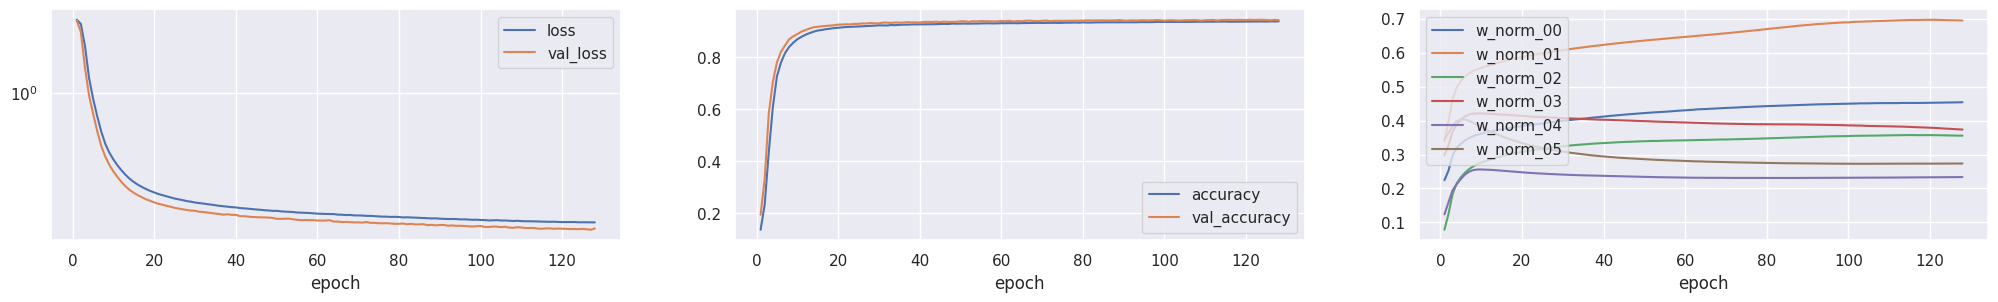

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(25,3))

with sns.axes_style("darkgrid"):
    sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
    axs[0].set_yscale("log");

    sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);

    sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [26]:
run.save_state(LOG_DIR, P, model)
weight_norm_logger.norms_to_csv(LOG_DIR)